In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import scipy as sp
from scipy import ndimage
import skimage.transform as sk_trans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load Airbus dataset

In [26]:
DATA_PATH = '/home/slawomirkapka/python-projects/ship-detection/data'
TRAIN_DATA = os.path.join(DATA_PATH, 'train')
df = pd.read_csv(DATA_PATH + '/train_ship_segmentations.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


## Plot 6 random images

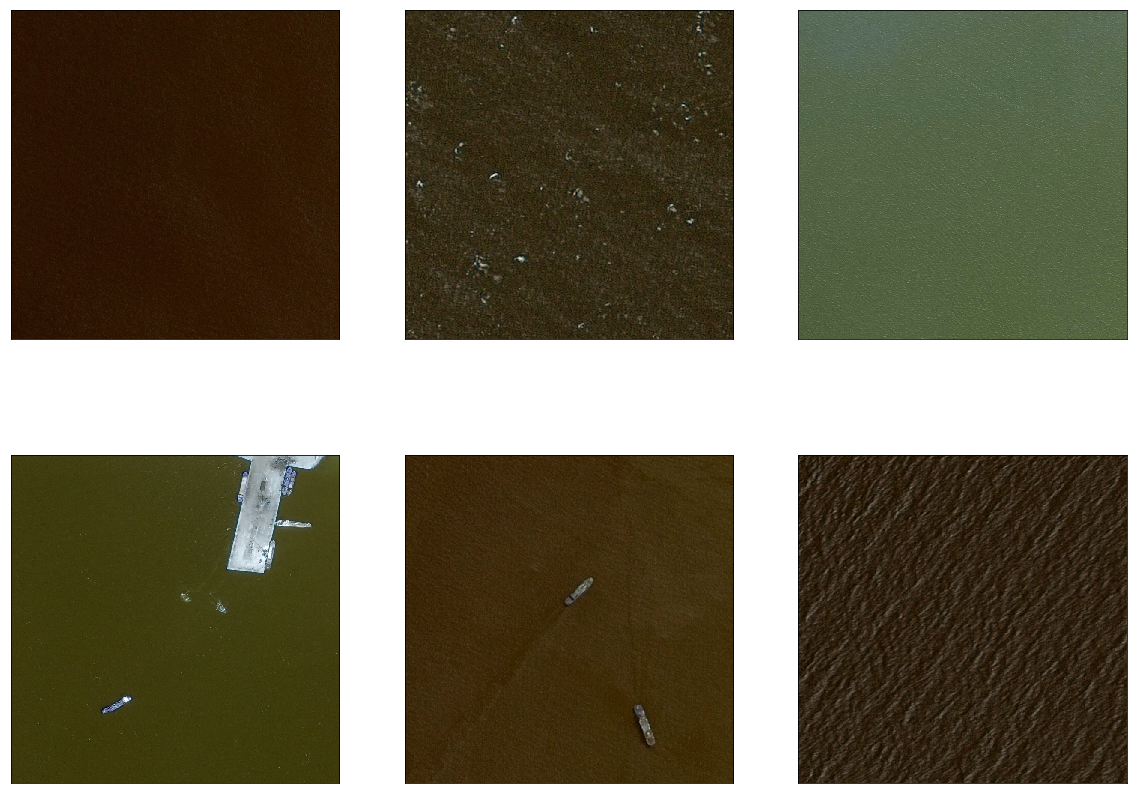

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15), subplot_kw={'xticks': [], 'yticks': []})
for ax in axes.flat:
    rand_id = int(np.random.uniform(300, 100000))
    some_img_name = df.loc[rand_id]['ImageId']
    some_img_path = os.path.join(TRAIN_DATA, some_img_name)
    image = cv2.imread(some_img_path)
    ax.imshow(image)
plt.show()

## Display images with masks from Id

In [40]:
def rle_decode_RGB(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape).T

def mask_overlay(image, mask):
    """
    Helper function to visualize mask
    """
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.75, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]  
    return img

def display(Id):
    some_img_name = df.loc[Id]['ImageId']
    some_img_mask_rle = df.loc[Id]['EncodedPixels']
    
    some_img_path = os.path.join(TRAIN_DATA, some_img_name)
    some_img = cv2.imread(some_img_path)
    
    if pd.isna(some_img_mask_rle):
        final_img = some_img
    else:
        some_img_mask = rle_decode_RGB(some_img_mask_rle)
        mask_rehsaped = np.stack((np.zeros_like(some_img_mask), some_img_mask, np.zeros_like(some_img_mask)), -1)
        final_img = mask_overlay(some_img, mask_rehsaped)
    return final_img

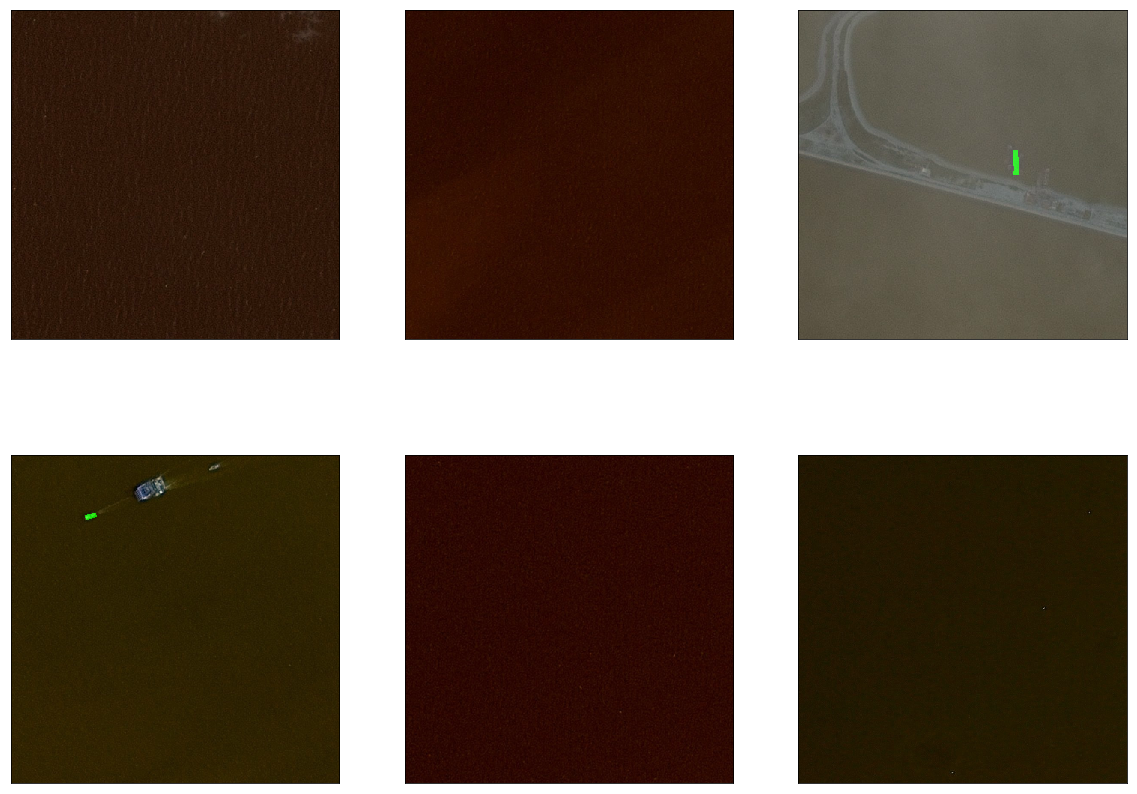

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15), subplot_kw={'xticks': [], 'yticks': []})
for ax in axes.flat:
    rand_id = int(np.random.uniform(0, df.shape[0]))
    image = display(rand_id)
    ax.imshow(image)
plt.show()

# Generate synthetic ships

## 1. Waves

In [43]:
def random_waves(grid_div):
    img_size = 768
    
    min_freq = grid_div * 0.05
    max_freq = grid_div * 0.4
    
    x = np.linspace(0,img_size,img_size)
    freq = np.random.uniform(min_freq, max_freq)
    sin = 0.5 * np.sin(freq * x)
    noise = np.random.rand(img_size)
    sin_noise = noise + sin
    
    horizontal_noise = np.stack([sin_noise for i in range(img_size)])
    additional_noise = 0.2 * (np.random.rand(img_size, img_size) + 1)
    random_intensity = np.random.uniform(0.4, 1)
    horizontal_waves = random_intensity*(horizontal_noise + additional_noise)
    
    angle = np.random.uniform(0, 180)
    rotated = sk_trans.rotate(horizontal_waves, angle)
    
    cropped = rotated[150: 600, 150: 600]
    final_waves = sk_trans.resize(cropped, (img_size, img_size))
    
    return final_waves

/home/slawomirkapka/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


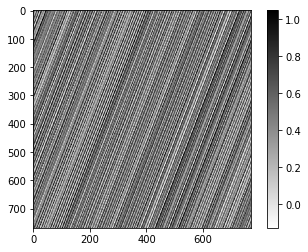

In [47]:
some_waves = random_waves(6)
plt.imshow(some_waves, cmap='binary')
plt.colorbar()
plt.show()

## 2. Random ships on waves and masks

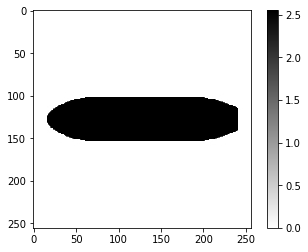

In [45]:
loaded = np.loadtxt('data/ship.csv', dtype=float)
the_ship = loaded * 10 ** (-2)
the_mask = np.zeros_like(the_ship, dtype = np.uint8)
the_mask[102:154, 16:241] = 1

img_size = 768
ship_size = 256

plt.imshow(the_ship)
plt.show()

In [48]:
def random_ship_streach(base_ship, base_mask):
    x_streach = np.random.uniform(0.5, 1.5)
    y_streach = np.random.uniform(0.8, 1.2)

    x_streach_size = int(ship_size * x_streach)
    y_streach_size = int(ship_size * y_streach)

    streached_ship = sk_trans.resize(base_ship, (y_streach_size, x_streach_size))
    streached_mask = sk_trans.resize(base_mask, (y_streach_size, x_streach_size))

    y_size, x_size = streached_ship.shape

    if x_size == y_size:
        squared_ship = streached_ship
        squared_mask = streached_mask
    elif x_size < y_size:
        squared_ship = np.zeros((y_size, y_size))
        squared_mask = np.zeros((y_size, y_size))
        diff = y_size - x_size
        x_offset = int(diff / 2)
        squared_ship[:, x_offset: x_offset + x_size] = streached_ship
        squared_mask[:, x_offset: x_offset + x_size] = streached_mask
    else:
        squared_ship = np.zeros((x_size, x_size))
        squared_mask = np.zeros((x_size, x_size))
        diff = x_size - y_size
        y_offset = int(diff / 2)
        squared_ship[y_offset: y_offset + y_size] = streached_ship
        squared_mask[y_offset: y_offset + y_size] = streached_mask

    resized_ship = sk_trans.resize(squared_ship, (ship_size, ship_size))
    resized_mask = sk_trans.resize(squared_mask, (ship_size, ship_size))
    
    return resized_ship, resized_mask

def random_ship_rotate(ship, mask):
    angle = np.random.uniform(0, 360)
    rotated_ship = sk_trans.rotate(ship, angle)
    rotated_mask = sk_trans.rotate(mask, angle)
    return rotated_ship, rotated_mask

def random_tranform_ship(base_ship, base_mask, grid_div):
    streached_ship, streached_mask = random_ship_streach(base_ship, base_mask)
    rotated_ship, rotated_mask = random_ship_rotate(streached_ship, streached_mask)
    maxsize = 0.9* img_size / grid_div
    scale = np.random.uniform(0.5, 1)
    final_size = int(maxsize * scale)
    random_ship = sk_trans.resize(rotated_ship, (final_size, final_size))
    random_ships_mask = sk_trans.resize(rotated_mask, (final_size, final_size))
    return random_ship, random_ships_mask

def add_ship(base_ship, base_mask, canvas, mask_background, grid_div, x_offset, y_offset):
    random_ship, random_ships_mask = random_tranform_ship(base_ship, base_mask, grid_div)
    random_intensity = np.random.uniform(0.8, 1.2)
    random_ship *= random_intensity
    y_top = y_offset+random_ship.shape[0]
    x_top = x_offset+random_ship.shape[1]
    if y_top < img_size and x_top < img_size:
        canvas[y_offset:y_top,x_offset:x_top] = np.maximum(canvas[y_offset:y_top,x_offset:x_top], random_ship)
        mask_background[y_offset:y_top,x_offset:x_top] = random_ships_mask
        
def random_ships(base_ship, base_mask, canvas, mask_background, grid_div, density):
    
    step = img_size / grid_div
    x_offset = int(step / 4)
    for x in range(grid_div):
        y_offset = int(step / 4)
        for y in range(grid_div):
            rand = np.random.uniform(0, 1)
            if rand < density:
                add_ship(base_ship, base_mask, canvas, mask_background, grid_div, x_offset, y_offset)
            y_offset += int(step)
        x_offset += int(step)

    return canvas, mask_background

## 3. Top noise

In [50]:
def top_noise():
    noise_size = int(np.random.uniform(4, 10))
    noise = np.random.rand(noise_size,noise_size)
    X = np.linspace(0, noise_size - 1, noise_size)
    Y = np.linspace(0, noise_size - 1, noise_size)
    x, y = np.meshgrid(X, Y)

    f = sp.interpolate.interp2d(x, y, noise, kind='cubic')

    X_new = np.linspace(0, noise_size - 1, img_size)
    Y_new = np.linspace(0, noise_size - 1, img_size)

    top_noise = f(X_new, Y_new)
    return top_noise

## 4. Combined

In [51]:
def random_img_mask(base_ship, base_mask):
    grid_div = int(np.random.uniform(3, 10))
    density = np.random.uniform(0, 0.3)
    
    canvas = random_waves(grid_div) + top_noise()
    mask_background = np.zeros((img_size, img_size))
    
    img, masks = random_ships(base_ship, base_mask, canvas, mask_background, grid_div, density)
    
    return img, masks

/home/slawomirkapka/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


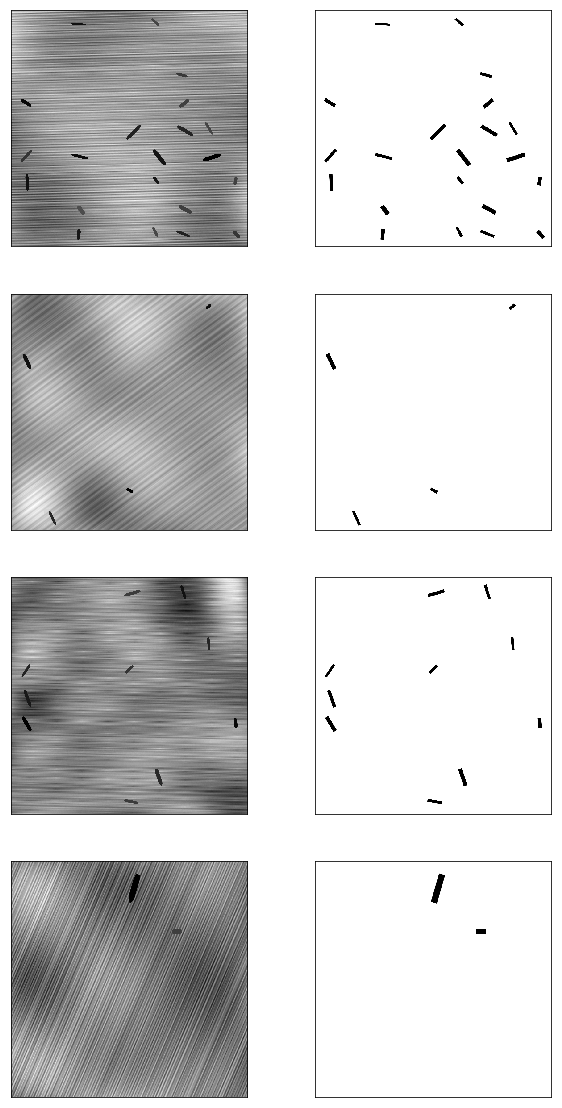

In [52]:
fig, axis = plt.subplots(4, 2, figsize = (10, 20), subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axis.flat):
    if i % 2 == 0:
        img, masks= random_img_mask(the_ship, the_mask)
        ax.imshow(img, cmap = 'binary')
    else:
        ax.imshow(masks, cmap = 'binary')
plt.show()